In [68]:
import xarray as xr 
import numpy as np
import matplotlib.pyplot as plt

import sys
sys.path.append('/home/users/cturrell/documents/eddy_feedback')
import functions.data_wrangling as data
import functions.eddy_feedback as ef

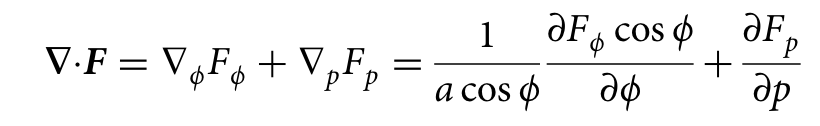

# SPARC SRIP Data

- EPF_phi_pr (epfy) = [m3 s-2]
- EPFD_phi_pr (div1) = [m s-2]

In [69]:
ep_fluxes = xr.open_mfdataset('/badc/srip/data/zonal/common_grid/era_interim/TEM_monthly*')
ucomp = xr.open_mfdataset('/badc/srip/data/zonal/common_grid/era_interim/ZMD_monthly*')

srip = xr.Dataset( {'EPF_phi_pr': ep_fluxes['EPF_phi_pr'], 'EPFD_phi_pr': ep_fluxes['EPFD_phi_pr'], 'ubar': ucomp.u } )

In [70]:
srip.time

<xarray.DataArray 'time' (time: 456)>
array(['1979-01-14T09:00:00.000000000', '1979-02-12T21:00:00.000000000',
       '1979-03-14T09:00:00.000000000', ..., '2016-10-14T09:00:00.000000000',
       '2016-11-13T21:00:00.000000000', '2016-12-14T09:00:00.000000000'],
      dtype='datetime64[ns]')
Coordinates:
  * time     (time) datetime64[ns] 1979-01-14T09:00:00 ... 2016-12-14T09:00:00
Attributes:
    description:    Time measured as days since 0001-01-01 0:0:0. Time of the...
    standard_name:  time
    frequency:      4 times per day
    cell_methods:   time: mean

## Plot original variables

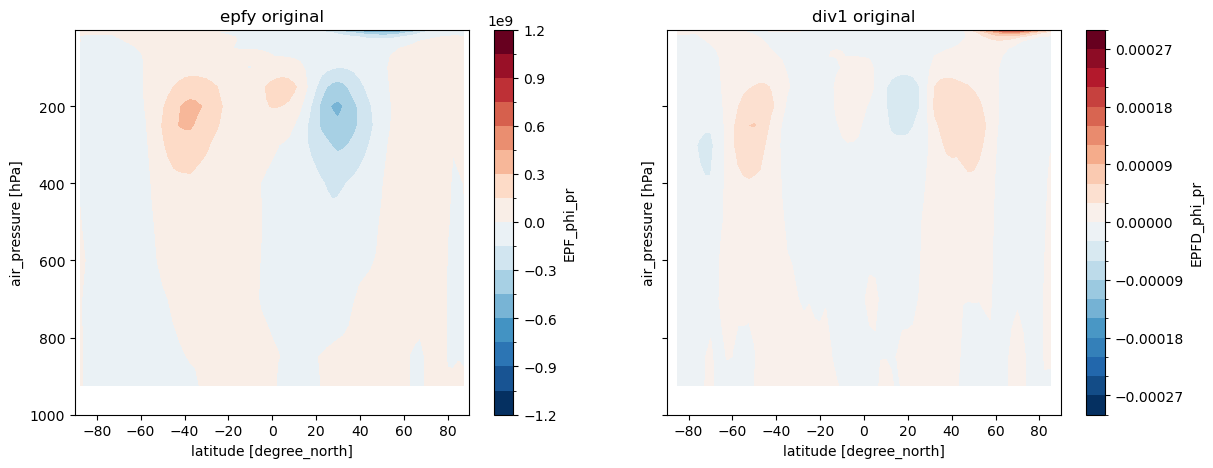

In [71]:
# calculate seasonal mean for orignal values
srip_djf = data.seasonal_mean(srip, season='djf')

# plot original SRIP dataset versions
fig, (ax1, ax2) = plt.subplots(ncols=2, sharey=True, figsize=(14,5))
srip_djf.EPF_phi_pr.mean('time').plot.contourf(ax=ax1, levels=20, yincrease=False)
srip_djf.EPFD_phi_pr.mean('time').plot.contourf(ax=ax2, levels=20, yincrease=False)
ax1.set_title('epfy original')
ax2.set_title('div1 original')
plt.show()

### Plot scaled versions of the originals

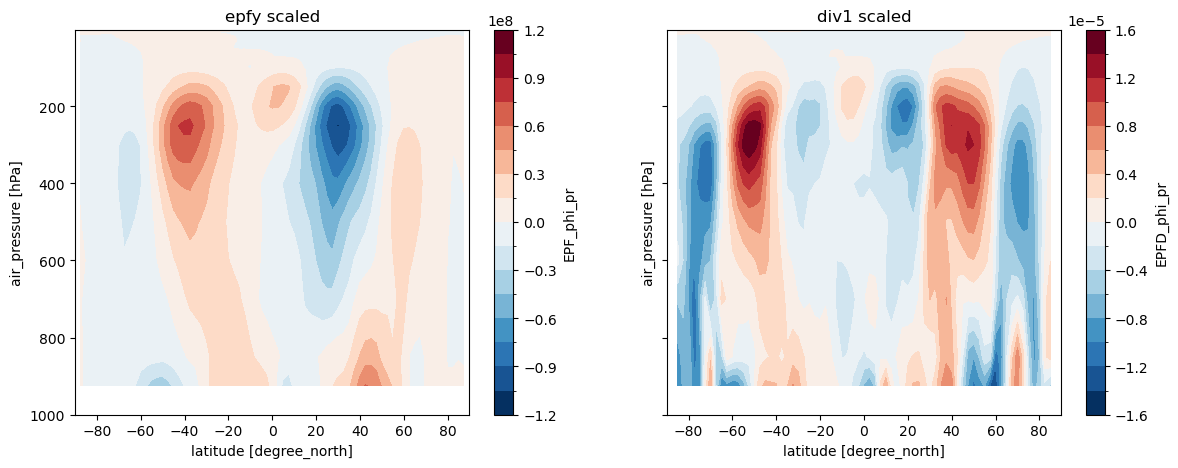

In [72]:
# scale variables epfy and divFy
srip_djf_scaled = data.seasonal_mean(srip, season='djf')
srip_djf_scaled['EPF_phi_pr'] = ef.pressure_scaling(srip_djf_scaled['EPF_phi_pr'])
srip_djf_scaled['EPFD_phi_pr'] = ef.pressure_scaling(srip_djf_scaled['EPFD_phi_pr'])

# plot scaled variables
fig, (ax1, ax2) = plt.subplots(ncols=2, sharey=True, figsize=(14,5))
srip_djf_scaled.EPF_phi_pr.mean('time').plot.contourf(ax=ax1, levels=20, yincrease=False)
srip_djf_scaled.EPFD_phi_pr.mean('time').plot.contourf(ax=ax2, levels=20, yincrease=False)
ax1.set_title('epfy scaled')
ax2.set_title('div1 scaled')
plt.show()

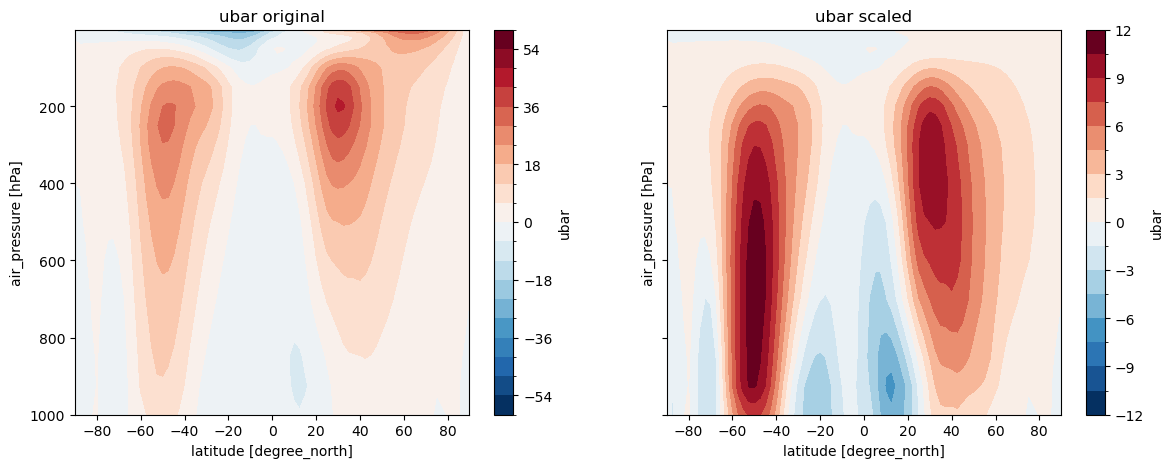

In [73]:
# calculate scaled version of ubar
ubar = srip_djf['ubar']
ubar = ef.pressure_scaling(ubar)

# plot ubar original vs scaled
fig, (ax1, ax2) = plt.subplots(ncols=2, sharey=True, figsize=(14,5))
srip_djf.ubar.mean('time').plot.contourf(ax=ax1, levels=20, yincrease=False)
ubar.mean('time').plot.contourf(ax=ax2, levels=20, yincrease=False)
ax1.set_title('ubar original')
ax2.set_title('ubar scaled')
plt.show()

## Compare calculated variables

Scaling applied.


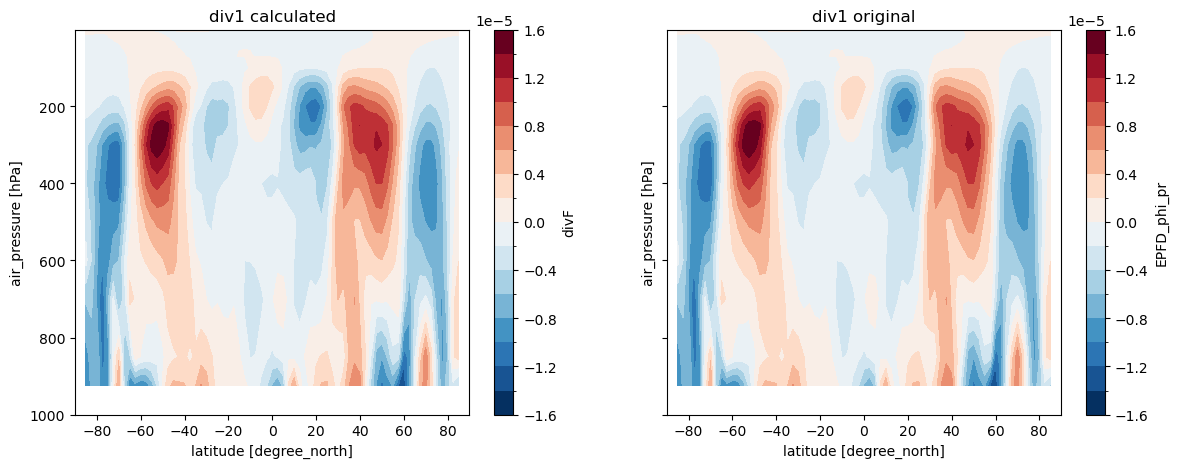

In [74]:
# pass epfy from SRIP dataset to calculate my own divFy
srip = ef.calculate_divFphi(srip)
srip_djf = data.seasonal_mean(srip, season='djf')

# Plot it
fig, (ax1, ax2) = plt.subplots(ncols=2, sharey=True, figsize=(14,5))
srip_djf.divF.mean('time').plot.contourf(ax=ax1, levels=20, yincrease=False)
srip_djf_scaled.EPFD_phi_pr.mean('time').plot.contourf(ax=ax2, levels=20, yincrease=False)
ax1.set_title('div1 calculated')
ax2.set_title('div1 original')
plt.show()

Calculated values have relative tolerance = $10^{-4}$

In [75]:
# test closeness of variables
np.testing.assert_allclose(srip_djf.divF.mean('time').values, srip_djf_scaled.EPFD_phi_pr.mean('time').values, rtol=1e-4)

### Eddy Feedback

In [76]:
efp_original = ef.calculate_efp(srip_djf, which_div1='EPFD_phi_pr')
efp_scaled = ef.calculate_efp(srip_djf_scaled, which_div1='EPFD_phi_pr')
efp_calculated = ef.calculate_efp(srip_djf, which_div1='divF')

print(f'EFP original: {efp_original} \nEFP scaled: {efp_scaled} \nEFP my calculations: {efp_calculated}')

EFP original: 0.4682 
EFP scaled: 0.4682 
EFP my calculations: 0.4682


![DivF.png](DivF.png)

# Own Calculations using Daily data

In [77]:
# pull in files
ep_fluxes = xr.open_mfdataset('/badc/srip/data/zonal/common_grid/jra_55/TEM_monthly*')
ucomp = xr.open_mfdataset('/badc/srip/data/zonal/common_grid/jra_55/ZMD_monthly*')

# create subset of data and calculate seasonal mean
srip_jra = xr.Dataset( {'EPF_phi_pr': ep_fluxes['EPF_phi_pr'], 'EPFD_phi_pr': ep_fluxes['EPFD_phi_pr'], 'ubar': ucomp.u } )
srip_jra_djf = data.seasonal_mean(srip_jra, season='djf')

In [78]:
srip_jra.time

<xarray.DataArray 'time' (time: 708)>
array(['1958-01-14T09:00:00.000000000', '1958-02-12T21:00:00.000000000',
       '1958-03-14T09:00:00.000000000', ..., '2016-10-14T09:00:00.000000000',
       '2016-11-13T21:00:00.000000000', '2016-12-14T09:00:00.000000000'],
      dtype='datetime64[ns]')
Coordinates:
  * time     (time) datetime64[ns] 1958-01-14T09:00:00 ... 2016-12-14T09:00:00
Attributes:
    description:    Time measured as days since 0001-01-01 0:0:0. Time of the...
    standard_name:  time
    frequency:      4 times per day
    cell_methods:   time: mean

In [79]:
# jra = xr.open_mfdataset('/gws/nopw/j04/arctic_connect/cturrell/reanalysis_data/jra55_daily/jra55_uvtw_ubar_ep.nc',
#                         parallel=True, chunks={'time':31})
# jra = jra[['u', 'ep1', 'div1']]
# jra = jra.sel(level=srip_jra_djf.level.values)
# jra['ubar'] = jra.u.mean('lon')

# # epfy has units m3 s-2
# lat_rads = np.deg2rad(jra.lat.values)
# coslat = np.cos(lat_rads)  
# a = 6.371e6
# jra['epfy'] = jra.ep1 * (a * coslat) 

# # divFy has units m s-2
# jra['divFy'] = jra['div1'] / 86400

# # subset dataset to match SRIP
# jra = jra.where(jra.level < 1000)
# jra = jra.where(jra.level > 1)
# jra = jra.where(jra.lat >= -87.5)
# jra = jra.where(jra.lat <= 87.5)

# jra_djf = data.seasonal_mean(jra, season='djf')
jra_djf = xr.open_mfdataset('jra_djf_matching-SRIP.nc')

### Correct epfy units

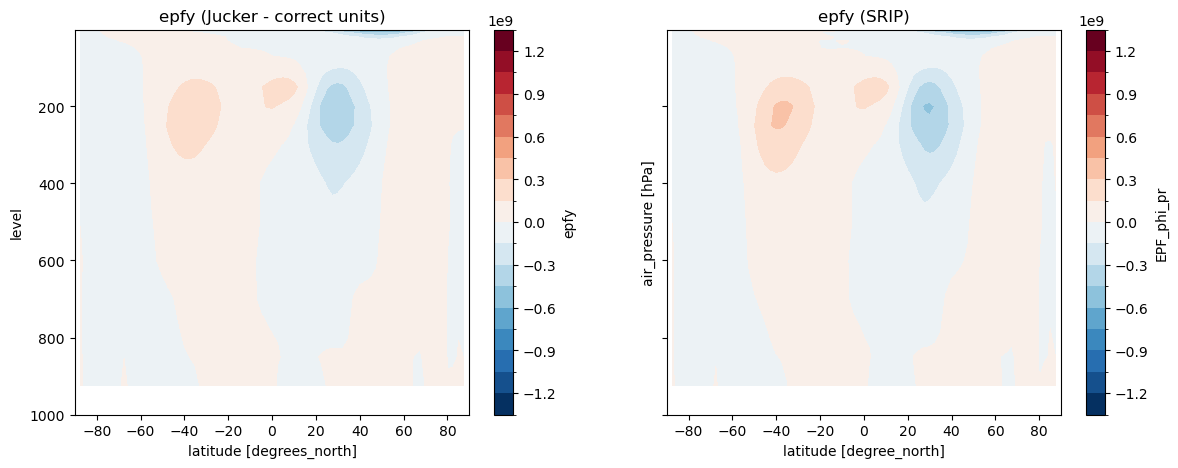

In [80]:
# plot epfy (ep1 * acos(phi)) to have same units [m3 s-2]
fig, (ax1, ax2) = plt.subplots(ncols=2, sharey=True, figsize=(14,5))

jra_djf.epfy.mean('time').plot.contourf(ax=ax1, levels=20, yincrease=False)
srip_jra_djf.EPF_phi_pr.mean('time').plot.contourf(ax=ax2, levels=20, yincrease=False)

ax1.set_title('epfy (Jucker - correct units)')
ax2.set_title('epfy (SRIP)')
plt.show()

Large mismatch all the way up to rtol=0.1

In [81]:
# 86% mistmatch at rtol=0.1
# np.testing.assert_allclose(jra_djf.epfy.mean('time').values, srip_jra_djf.EPF_phi_pr.mean('time').values, rtol=1e-0)

### Correct divF units

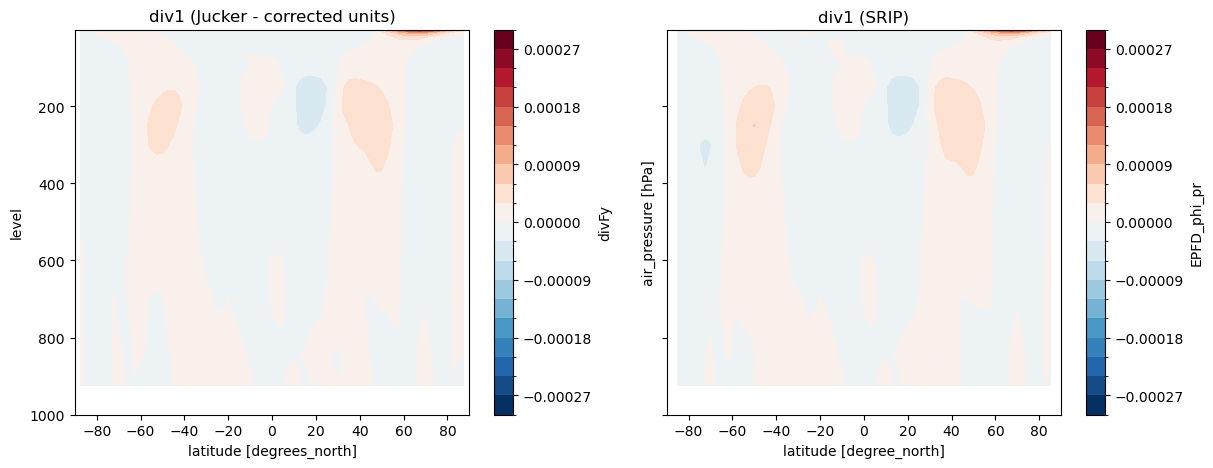

In [82]:
fig, (ax1, ax2) = plt.subplots(ncols=2, sharey=True, figsize=(14,5))

jra_djf.divFy.mean('time').plot.contourf(ax=ax1, levels=20, yincrease=False)
srip_jra_djf.EPFD_phi_pr.mean('time').plot.contourf(ax=ax2, levels=20, yincrease=False)
ax1.set_title('div1 (Jucker - corrected units)')
ax2.set_title('div1 (SRIP)')
plt.show()

In [83]:
# # Massive mismatch too
# np.testing.assert_allclose(jra_djf.divFy.mean('time').values, srip_jra_djf.EPFD_phi_pr.mean('time').values, rtol=1e-4)

### Compare own calculations

Scaling applied.


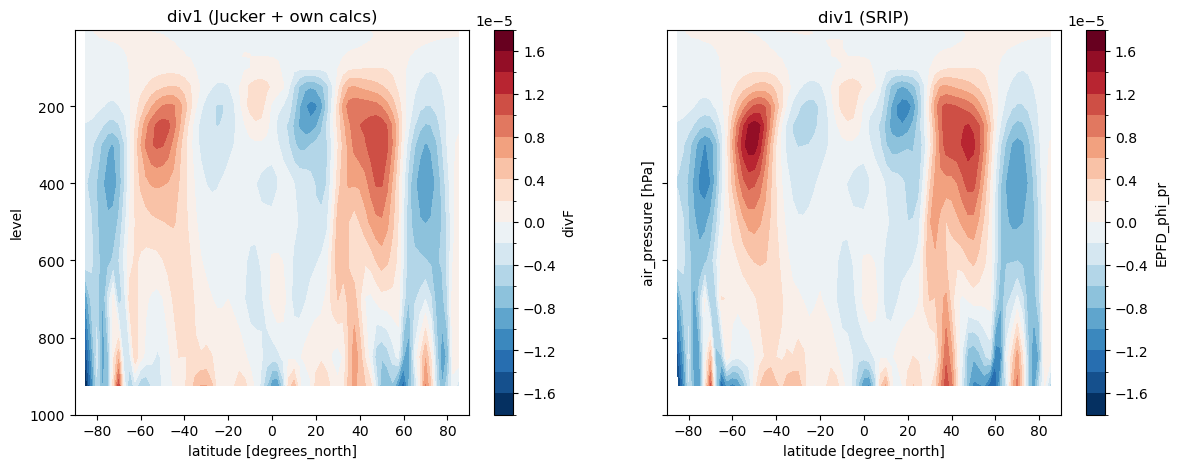

In [84]:
# calculate scaled values for JRA55 SRIP dataset and overwrite vars
srip_jra_djf_scaled = data.seasonal_mean(srip_jra, season='djf')
srip_jra_djf_scaled['EPF_phi_pr'] = ef.pressure_scaling(srip_jra_djf_scaled['EPF_phi_pr'])
srip_jra_djf_scaled['EPFD_phi_pr'] = ef.pressure_scaling(srip_jra_djf_scaled['EPFD_phi_pr'])

# calculate divFphi and add
jra_djf = ef.calculate_divFphi(jra_djf, which_Fphi='epfy')

# plot my own calculations of epfy vs SRIP
fig, (ax1, ax2) = plt.subplots(ncols=2, sharey=True, figsize=(14,5))

jra_djf['divF'].mean('time').plot.contourf(ax=ax1, levels=20, yincrease=False)
srip_jra_djf_scaled.EPFD_phi_pr.mean('time').plot.contourf(ax=ax2, levels=20, yincrease=False)

ax1.set_title('div1 (Jucker + own calcs)')
ax2.set_title('div1 (SRIP)')
plt.show()

### Compare own calculations with scaled

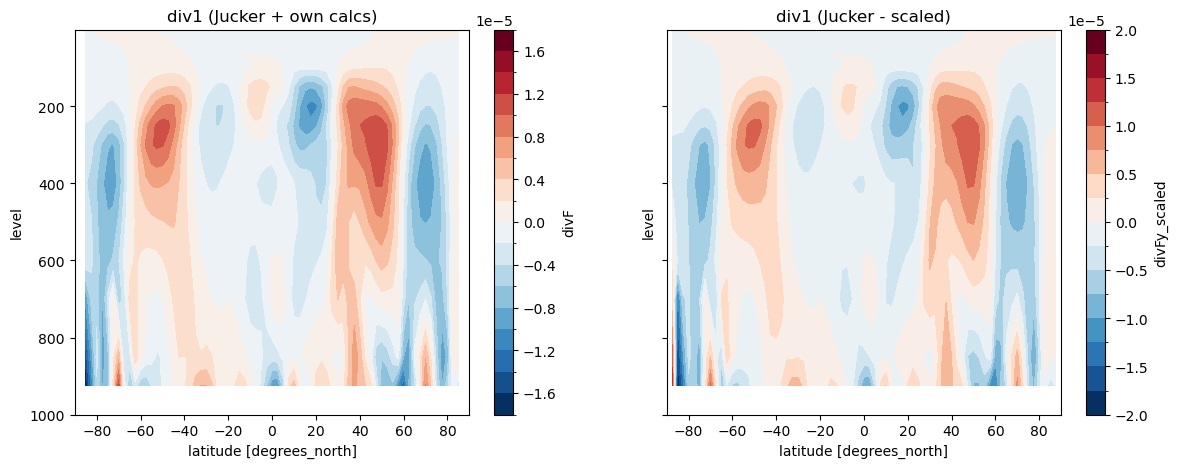

In [85]:
# plot my own calculations of epfy vs Jucker's div1
fig, (ax1, ax2) = plt.subplots(ncols=2, sharey=True, figsize=(14,5))

jra_djf['divFy_scaled'] = ef.pressure_scaling(jra_djf.divFy)

jra_djf['divF'].mean('time').plot.contourf(ax=ax1, levels=20, yincrease=False)
jra_djf['divFy_scaled'].mean('time').plot.contourf(ax=ax2, levels=20, yincrease=False)

ax1.set_title('div1 (Jucker + own calcs)')
ax2.set_title('div1 (Jucker - scaled)')
plt.show()

## Eddy Feedback Parameter

In [86]:
efp_srip_original = ef.calculate_efp(srip_jra_djf, which_div1='EPFD_phi_pr')
efp_srip_scaled = ef.calculate_efp(srip_jra_djf_scaled, which_div1='EPFD_phi_pr')

print('SRIP datasets:')
print(f'EFP original (SRIP): {efp_srip_original} \nEFP scaled (SRIP): {efp_srip_scaled}')
efp_me_original = ef.calculate_efp(jra_djf, which_div1='divFy')
efp_me_scaled = ef.calculate_efp(jra_djf, which_div1='divFy_scaled')

efp_me_calculated = ef.calculate_efp(jra_djf, which_div1='divF')

print('\nMy calculations with daily data:')
print(f'EFP Jucker: {efp_me_original} \nEFP my calculations: {efp_me_calculated}')

SRIP datasets:
EFP original (SRIP): 0.4646 
EFP scaled (SRIP): 0.4646

My calculations with daily data:
EFP Jucker: 0.3962 
EFP my calculations: 0.397


## Check ubar difference

In [104]:
# pull in files
ep_fluxes = xr.open_mfdataset('/badc/srip/data/zonal/common_grid/jra_55/TEM_monthly*')
ucomp = xr.open_mfdataset('/badc/srip/data/zonal/common_grid/jra_55/ZMD_monthly*')

# create subset of data and calculate seasonal mean
srip_jra = xr.Dataset( {'EPF_phi_pr': ep_fluxes['EPF_phi_pr'], 'EPFD_phi_pr': ep_fluxes['EPFD_phi_pr'], 'ubar': ucomp.u } )
srip_jra = srip_jra.rename({'pressure': 'level', 'latitude': 'lat'})

### DJF all years

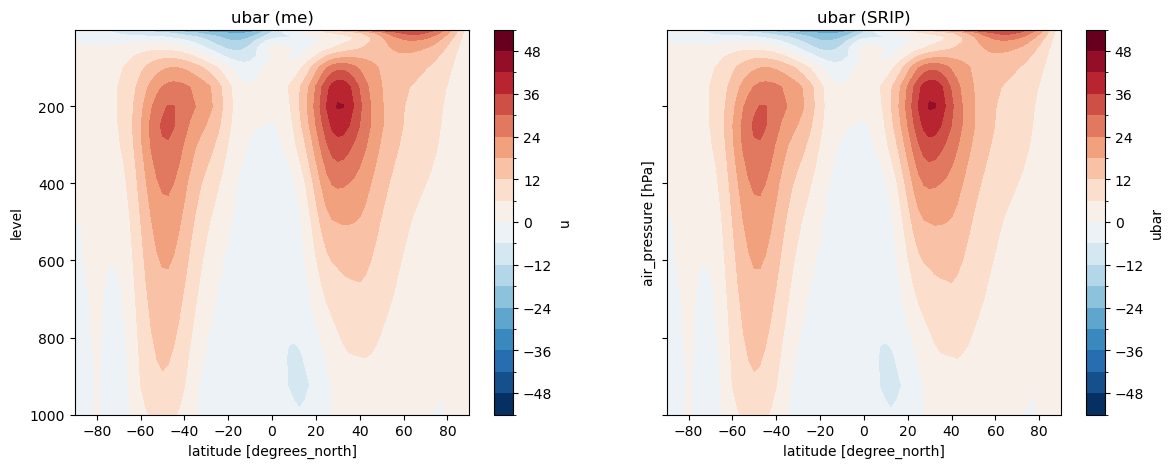

In [112]:
jra = xr.open_mfdataset('/gws/nopw/j04/arctic_connect/cturrell/reanalysis_data/jra55_daily/jra55_uvtw_ubar_ep.nc',
                        parallel=True, chunks={'time':31})

jra = jra.sel(level=srip_jra_djf.level.values)
ubar = jra.u.mean('lon')
ubar = data.seasonal_mean(ubar, season='djf')

# plot ubar difference
plot = ubar.mean('time') - srip_jra_djf.ubar.mean('time')
plot.plot.contourf(levels=20, yincrease=False)

### DJF first season

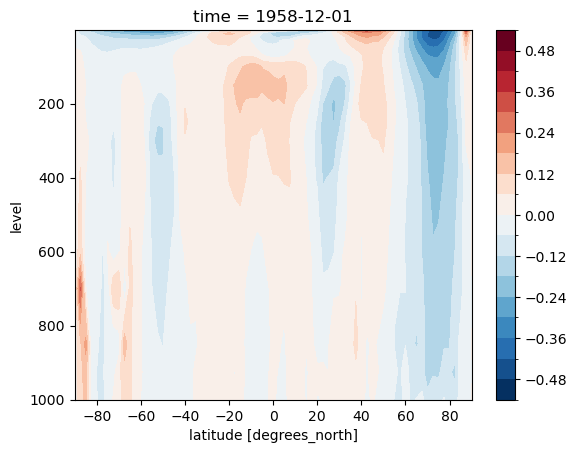

In [115]:
jra = xr.open_mfdataset('/gws/nopw/j04/arctic_connect/cturrell/reanalysis_data/jra55_daily/jra55_uvtw_ubar_ep.nc',
                        parallel=True, chunks={'time':31})

jra = jra.sel(level=srip_jra_djf.level.values)
ubar = jra.u.mean('lon')
ubar = data.seasonal_mean(ubar, season='djf')

# plot ubar difference
diff = ubar.isel(time=0) - srip_jra_djf.ubar.isel(time=0)
diff.plot.contourf(levels=20, yincrease=False)

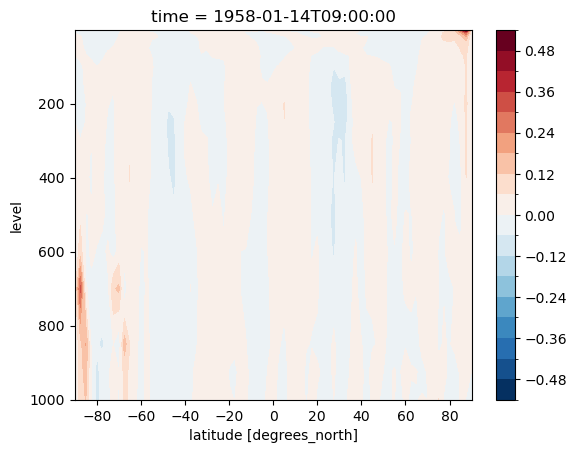

In [116]:
jra = xr.open_mfdataset('/gws/nopw/j04/arctic_connect/cturrell/reanalysis_data/jra55_daily/jra55_uvtw_ubar_ep.nc',
                        parallel=True, chunks={'time':31})

jra = jra.sel(level=srip_jra_djf.level.values)
ubar = jra.u.mean('lon')
ubar = ubar.sel(time='1958-01').mean('time')

# plot difference
diff = ubar - srip_jra.ubar.sel(time='1958-01')
diff.isel(time=0).plot.contourf(levels=20, yincrease=False)